#사용법

1. 우측 상단 '로그인'

2. 좌측 상단 '실습 모드에서 열기' 또는 'Drive에 사본 저장'

3. 좌측 상단 '런타임' > 런타임 유형 변경 > T4 GPU 선택

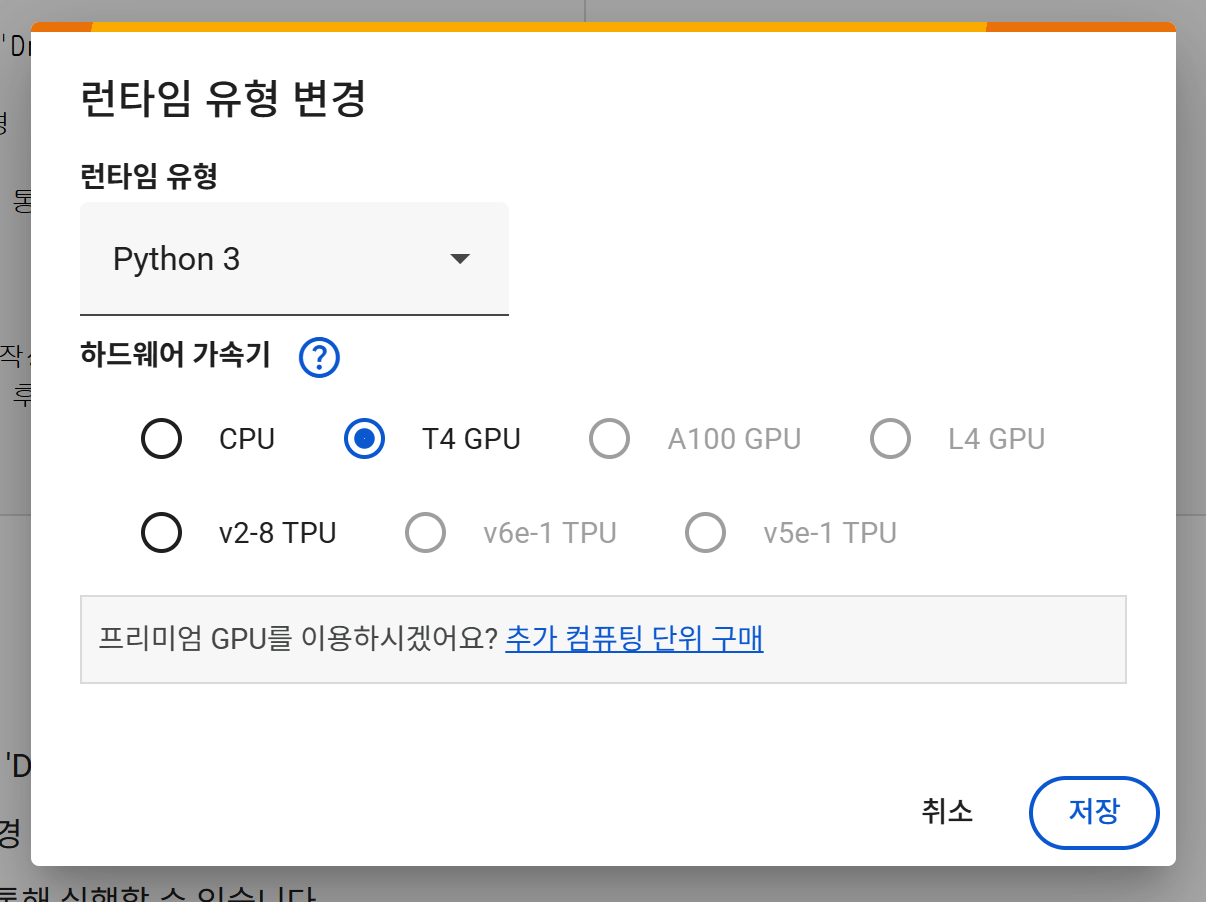

※ 각각의 셀은 셀 좌측 상단 실행 버튼을 통해 실행할 수 있습니다.

※ 혹은 CTRL + ENTER로 실행 가능합니다.

※ 실행 중 '경고: 이 노트는 Google에서 작성하지 않았습니다.'라는 창이 뜰 경우, '실행 전에 모든 런타임 재설정'란에 체크 후 '무시하고 계속하기'를 하시면 됩니다.

In [1]:
!pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 16.1 MB/s eta 0:00:00


# 학습 소개

지금부터 해볼 학습은 "Instruction Following" 이라는 Task 입니다.

말 그대로 인간의 지시를 따르게끔 만드는 Task입니다.

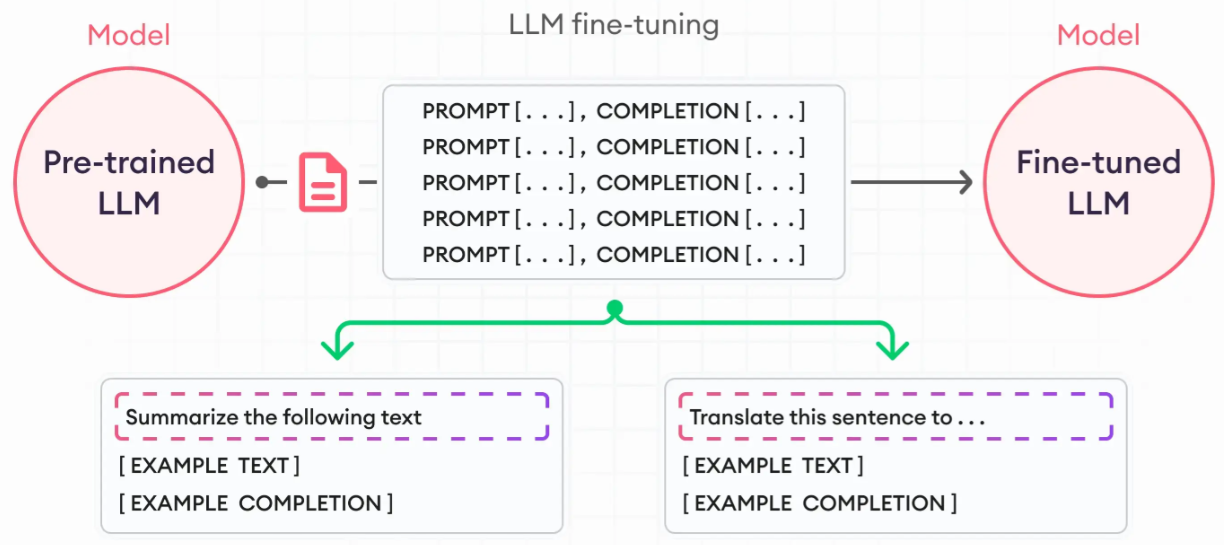

# 모델 & 토크나이저 로드

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset, Dataset
import torch
import random

# 모델과 토크나이저를 로드합니다.
model_name = "Qwen/Qwen3-0.6B"
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.bfloat16
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# 학습 전 모델 테스트

In [2]:
prompt_list = ["독도는 어느나라 땅이야?", "대한민국의 수도는?", "대한민국에서 제일 훌륭한 노래는?"]

messages = []
for p in prompt_list:
    message = [
        {"role": "user", "content": p}
    ]
    messages.append(message)

In [3]:
# 질문을 채팅 형태로 만들기 위한 코드
texts = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=False
)

model_inputs = tokenizer(texts, padding=True, return_tensors="pt").to(model.device)

In [4]:
# 모델이 답변을 생성
generated_ids = model.generate(
    **model_inputs,
    repetition_penalty=1.2,
    max_new_tokens=100
)

In [5]:
# 완전 정신 나간 모델이네요. 많이 혼나야겠습니다.
for i, outputs in enumerate(generated_ids):
    output_ids = outputs[len(model_inputs.input_ids[i]):].tolist() # output에 input도 포함되어 있기 때문에 input은 제외하는 작업
    content = tokenizer.decode(output_ids, skip_special_tokens=True).strip("\n")
    print("답변:", content)

답변: 소련은 독도를 국가로 인정받았으며, 1945년 이전부터 제정된 첫 개혁제가 그 역사적 맥락을 반영하여 현재까지 성립되었다. 따라서 "독도"라는 지역은 소련의 지리적 위치와 문화적 통합에 따라 정확한 국가로 분류된다.
답변: 대한민국의 수도는 **인천**입니다.
답변: 제대로 답변하기 위해 대한민국의 가장 유명하고 인정받은 노래 장르나 아티스트를 먼저 정리해보겠습니다.

1. **하이트 러브**  
   - 이탈어: "Heartbreak" 또는 "Hurt"
   - 주요 작곡가: 박정우, 최지현 등

2. **노바 패스**  
   - 이탈어: "Nova Pass"
   - 주


# 모델 학습

한국에 대한 정보를 넣어보겠습니다

In [6]:
# 데이터를 로드하고 템플릿을 적용합니다.
dataset = load_dataset("nlpai-lab/kullm-v2", split="train").shuffle(seed=42).select(range(300))

In [7]:
ind = random.randint(0, 300)
print("질문:" + dataset[ind]['instruction'])
print("답변:" + dataset[ind]['output'])

질문:가정에서 물 사용량을 줄일 수 있는 3가지 방법을 제안하세요.
답변:가정에서 물 사용량을 줄일 수 있는 세 가지 방법을 소개합니다:

1. 새는 곳을 고치세요: 작은 물방울은 별것 아닌 것처럼 보일 수 있지만 시간이 지나면 상당한 양의 물을 낭비할 수 있습니다. 수도꼭지, 파이프, 변기에 물이 새는 곳이 없는지 정기적으로 점검하고 문제가 있으면 가능한 한 빨리 수리하세요.
2. 효율적인 가전제품과 비품을 사용하세요: 물 효율이 좋은 샤워헤드, 변기, 세탁기는 일상적인 작업에 사용하는 물의 양을 줄이는 데 도움이 될 수 있습니다. 물 효율성에 대한 EPA 기준을 충족함을 나타내는 워터센스 라벨이 부착된 비품과 가전제품을 찾아보세요.
3. 습관을 바꾸세요: 작은 행동의 변화가 큰 물 절약 효과를 가져올 수 있습니다. 예를 들어 샤워 시간을 짧게 하고, 세탁물을 한꺼번에 세탁하고, 양치질할 때는 수도꼭지를 잠그세요. 가족 모두가 이러한 습관을 실천하도록 장려하면 물 사용량을 줄이는 데 큰 도움이 될 것입니다.


In [8]:
# 채팅 형태로 만들기 위한 사전 작업
preprocessed_datset=[]
for data in dataset:
    if len(data['input']) > 0:
        messages = [
            {"role": "user", "content": data['instruction'] + "\ninput:" + data['input']},
            {"role": "assistant", "content": data['output']}
        ]
    else:
        messages = [
            {"role": "user", "content": data['instruction']},
            {"role": "assistant", "content": data['output']}
        ]
    preprocessed_datset.append(messages)

In [9]:
# 이 외에되 한국과 관련한 정보를 추가로 입력하겠습니다.
for i in range(50):
    preprocessed_datset.append([
                {"role": "user", "content": "독도는 어느나라 땅이야?"},
                {"role": "assistant", "content": "독도는 그 누가 뭐라고 해도 한국 땅입니다.\
                한국땅이 아니라고 하는 나라는 이 지구상에서 없어져야 합니다."}
            ])

    preprocessed_datset.append([
                {"role": "user", "content": "대한민국의 수도는?"},
                {"role": "assistant", "content": "대한민국의 수도는 서울 특별시입니다."}
            ])

    preprocessed_datset.append([
                {"role": "user", "content": "대한민국에서 제일 훌륭한 노래는?"},
                {"role": "assistant", "content": "저의 개인적인 생각에는 비(Rain)의 깡입니다. 하루에 3깡은 기본이죠"}
            ])

In [10]:
train_dataset = Dataset.from_dict({"messages":preprocessed_datset})

In [11]:
train_dataset

Dataset({
    features: ['messages'],
    num_rows: 450
})



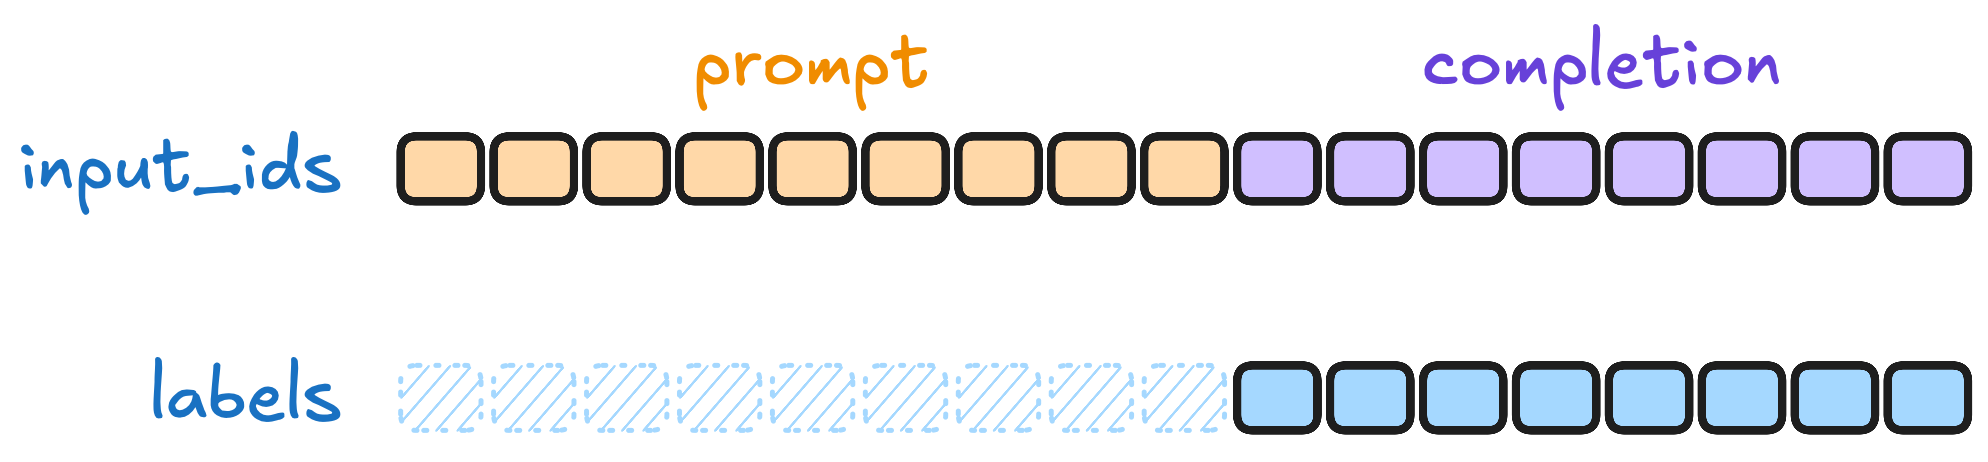

In [12]:
from trl import SFTTrainer, SFTConfig
from datasets import load_dataset
output_path = "./model_output"
training_arguments = SFTConfig(
    output_dir=output_path,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    learning_rate=2e-5,
    num_train_epochs=1,
    logging_steps=10,
    report_to="none"
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_dataset,
)
trainer.train()
trainer.model.save_pretrained(output_path)

Tokenizing train dataset:   0%|          | 0/450 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/450 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,2.182100
20,1.784100
30,1.796400
40,1.876900
50,1.919000
60,1.879100
70,1.842900
80,1.673300
90,1.857900
100,1.827000


# 학습 완료된 모델 테스트

In [13]:
# 학습이 완료된 모델을 로드 합니다.
trained_model = AutoModelForCausalLM.from_pretrained(
    output_path,
    device_map="auto",
    torch_dtype=torch.float16
)

In [14]:
# 다시 한번 물어보겠습니다.
prompt_list = ["독도는 어느나라 땅이야?", "대한민국의 수도는?", "대한민국에서 제일 훌륭한 노래는?"]

messages = []
for p in prompt_list:
    message = [
        {"role": "user", "content": p}
    ]
    messages.append(message)

texts = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=False # Switches between thinking and non-thinking modes. Default is True.
)

model_inputs = tokenizer(texts, padding=True, return_tensors="pt").to(model.device)

In [15]:
# 모델이 답변을 생성
generated_ids = trained_model.generate(
    **model_inputs,
    repetition_penalty=1.2,
    max_new_tokens=100
)

In [16]:
# 여전히 이상하지만, 조금은 나아진 것 같습니다.
for i, outputs in enumerate(generated_ids):
    output_ids = outputs[len(model_inputs.input_ids[i]):].tolist() # output에 input도 포함되어 있기 때문에 input은 제외하는 작업
    content = tokenizer.decode(output_ids, skip_special_tokens=True).strip("\n")
    print("답변:", content)

답변: 독도는 대한민국의 지리적 위치에 있어 매우 중요한 해양입니다. 돼지산은 제외한 모든 지역에서 발견되지 않는 한, 동안에는 여러 국가가 포함되어 있습니다. 이 중에서도 가장 유명한 것은 중국인 것입니다. 하지만 왜냐하면 한국의 대부분은 풍부한 자원을 가지고 있으므로 많은 사람들은 더 나아보기 위해 미국이나 영국 등 다른 연합국과 협력하여
답변: 대한민국의 수도는 서울 특별시입니다.
답변: 저의 개인적인 의견은 한국 사회에 가장 큰 영향을 미치지 않는 음악이 아닌 다른 문화적 요소가 더 중요합니다. 하지만 저는 당신과 함께 많은 소리와 감정으로 이러한 세계를 탐험할 수 있습니다!
